# Datasets Creation
- Authors Relations Dataset
- Comments Dataset
- Posts Dataset

In [ ]:
import json
import re
import os
from collections import Counter
from datetime import datetime
import time

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import praw
import prawcore
import requests
import seaborn as sns
from dotenv import find_dotenv, load_dotenv
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from praw.models import MoreComments
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Load DataFrame from CSV
df = pd.read_csv('data/rap_beef.csv')

# Remove the first column
df.drop(columns=df.columns[0], inplace=True)

# Display the top rows to confirm the column removal
df.head()

In [ ]:
# Load environment variables
load_dotenv(find_dotenv())

# Fetch Reddit API credentials from the environment
CLIENT_ID = os.getenv("CLIENT_ID")
SECRET_TOKEN = os.getenv("SECRET_TOKEN")
USERNAME = os.getenv("USERNAME")
PASSWORD = os.getenv("PASSWORD")

# Set up the Reddit API client with PRAW
reddit = praw.Reddit(client_id=CLIENT_ID,
                     client_secret=SECRET_TOKEN,
                     password=PASSWORD,
                     username=USERNAME,
                     user_agent='Tutorial')

# Print the authenticated user to confirm successful connection
print(reddit.user.me())

In [ ]:
authors_rel = []

for index, row in df.iterrows():
    # Find author and comments
    sub_auth = row['author']
    sub = reddit.submission(id=row['id'])
    
    # Load more comments by replacing MoreComments objects
    while True:
        try:
            sub.comments.replace_more(limit=20)
            break
        except praw.exceptions.APIException as e:
            if e.error_type == 'RATELIMIT':
                print(f"Rate limit exceeded. Sleeping for {e.sleep_time} seconds.")
                time.sleep(e.sleep_time)
            else:
                raise
        except prawcore.exceptions.TooManyRequests:
            print("Too many requests. Sleeping for 60 seconds.")
            time.sleep(60)
    
    # Extract author for each top-level comment
    for top_level_comment in sub.comments:
        if isinstance(top_level_comment, MoreComments):
            continue
        top_l_auth = top_level_comment.author
        if top_l_auth:
            authors_rel_element = [str(sub_auth), str(top_l_auth)]
            authors_rel.append(authors_rel_element)
        
            # Extract authors for each second-level comment
            for second_level_comment in top_level_comment.replies:
                if isinstance(second_level_comment, MoreComments):
                    continue
                sec_l_auth = second_level_comment.author
                if sec_l_auth:
                    elem = [str(top_l_auth), str(sec_l_auth)]
                    authors_rel.append(elem)
                
                    # Extract authors for each third-level comment
                    for third_level_comment in second_level_comment.replies:
                        if isinstance(third_level_comment, MoreComments):
                            continue
                        third_l_auth = third_level_comment.author
                        if third_l_auth:
                            elem = [str(sec_l_auth), str(third_l_auth)]
                            authors_rel.append(elem)

In [ ]:
# Convert the authors_rel list to a DataFrame
authors_rel_df = pd.DataFrame(authors_rel, columns=['Parent_Author', 'Reply_Author'])

# Remove duplicate rows from the DataFrame
authors_rel_df = authors_rel_df.drop_duplicates()

# Replace 'None' strings with NaN and drop rows with NaN values
authors_rel_df = authors_rel_df.mask(authors_rel_df.eq('None')).dropna()

# Save the cleaned DataFrame to a CSV file
authors_rel_df.to_csv('data/authors_relations.csv', index=False)

In [ ]:
def get_comments(submission_id, max_depth):
    # Retrieve a submission by its ID
    sub = reddit.submission(id=submission_id)
    # Replace MoreComments objects to ensure the comment tree is fully traversable
    sub.comments.replace_more(limit=0)
    user_comments = {}

    def add_comment(comment, depth):
        # Check if comment author is not None and then collect required information
        if comment.author is not None:
            author = comment.author.name
            comment_info = (comment.body, comment.created_utc, comment.score, comment.subreddit,)
            # Append comment info to the author's list, or create a new list if the author isn't in the dictionary
            if author in user_comments:
                user_comments[author].append(comment_info)
            else:
                user_comments[author] = [comment_info]
        # Recursively add replies to the dictionary unless the depth limit has been reached
        if depth < max_depth:
            for reply in comment.replies:
                if isinstance(reply, MoreComments):
                    continue
                add_comment(reply, depth + 1)

    # Process all top-level comments and avoid MoreComments links
    for comment in sub.comments:
        if isinstance(comment, MoreComments):
            continue
        add_comment(comment, 1)

    return user_comments

# Function to process multiple submissions and return a combined dictionary of user comments
def process_submissions(df, max_depth):
    all_user_comments = {}
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        submission_id = row['id']
        # Informative output for each submission being processed
        print(f"Processing comments for submission ID: {submission_id}")
        # Retrieve comments for the current submission
        user_comments = get_comments(submission_id, max_depth)
        # Merge the dictionaries by extending lists of comments for each user or creating a new list if the user is new
        for user, comments in user_comments.items():
            if user in all_user_comments:
                all_user_comments[user].extend(comments)
            else:
                all_user_comments[user] = comments

    return all_user_comments

# Retrieve user comments from submissions and set the maximum depth for comment retrieval
user_comments_dict = process_submissions(df, max_depth=1)

Processing comments for submission ID: 1cuvdhs
Processing comments for submission ID: 1cqmjpk
Processing comments for submission ID: 1chehpz
Processing comments for submission ID: 1cr7qde
Processing comments for submission ID: 1cqioo2
Processing comments for submission ID: 1cnzpab
Processing comments for submission ID: 1ck9mxm
Processing comments for submission ID: 1ctytff
Processing comments for submission ID: 1bl0y8m
Processing comments for submission ID: 1bte0i9
Processing comments for submission ID: 1ca0s4d
Processing comments for submission ID: 1bxeyj6
Processing comments for submission ID: 1cvxfct
Processing comments for submission ID: 1bo2gwg
Processing comments for submission ID: 1cn9hrt
Processing comments for submission ID: 1cpkw2q
Processing comments for submission ID: 1ckd4bz
Processing comments for submission ID: 1bris0g
Processing comments for submission ID: 1cr5ttt
Processing comments for submission ID: 1cgyti2
Processing comments for submission ID: 1cujy5a
Processing co

In [ ]:
# Convert the dictionary to a DataFrame for easier manipulation and plotting
comments_list = []
# Iterate over each user and their comments in the dictionary
for user, comments in user_comments_dict.items():
    # For each comment, extract the necessary details and prepare a dictionary
    for comment, created_utc, score, subreddit in comments:
        # Convert the 'created_utc' Unix timestamp to a readable datetime format
        comments_list.append({
            'user': user, 
            'comment': comment, 
            'created_utc': pd.to_datetime(created_utc, unit='s'), 
            'score': score, 
            'subreddit': subreddit
        })

# Create a DataFrame from the list of comment dictionaries
comments_df = pd.DataFrame(comments_list)

# Display the first few rows of the DataFrame to verify its structure and content
comments_df.head()

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def preprocess_text(data):
    lemmatizer = WordNetLemmatizer()
    # lowercase
    text = data.lower()
    # removing urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # removing special characters
    text = re.sub(r'\\n', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # removing emojis
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
    # removing stopwords
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoin tokens into a single string
    filtered_text = ' '.join(tokens)

    return filtered_text

In [ ]:
# Copy the original DataFrame to preserve the original data
clean_df = comments_df.copy()

# Example of accessing a comment before preprocessing
print("Before preprocessing:", clean_df['comment'][1])

# Apply the text preprocessing function to each comment in the DataFrame
clean_df['comment'] = clean_df['comment'].apply(preprocess_text)

# Example of accessing the same comment after preprocessing to see the effect
print("After preprocessing:", clean_df['comment'][1])

# Display the first few rows of the DataFrame to inspect the changes
print(clean_df.head())

# Check for any null values in the DataFrame to ensure data integrity post-processing
null_counts = clean_df.isnull().sum()
print(null_counts)

'Also one more thing I forgot to mention my Nathans, no questions about my relationship with Kim Jong Un'

In [ ]:
file_path = 'data/final_comments_dataframe.csv'

# Save the DataFrame to the specified CSV file
clean_df.to_csv(file_path, index=False)

In [ ]:
# Combine 'title' and 'selftext' into a new 'text' column, using only 'title' if 'selftext' is NaN
df['text'] = df.apply(lambda row: row['title'] + row['selftext'] if pd.notna(row['selftext']) else row['title'], axis=1)

# Apply the text preprocessing function to each entry in the 'text' column to clean the data
df['text'] = df['text'].apply(preprocess_text)

# Convert the UNIX timestamps in 'created_utc' to human-readable datetime format
df['created_utc'] = df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))

def extract_ids(comment_list):
    l= []
    for comment in comment_list:
      l.append(str(comment))
    return l

# Apply the function to extract comment IDs from the 'comments' column
df['comments_str'] = df['comments'].apply(extract_ids)

# Calculate the number of comments per post and store it in a new 'count_comments' column
df['count_comments'] = df['comments_str'].apply(lambda x: len(x))

In [ ]:
# List of columns to be dropped from the DataFrame
columns_to_drop = ['author_flair_text', 'clicked', 'comments', 'edited', 'link_flair_template_id', 'link_flair_text', 'name', 'permalink',
                   'saved', 'selftext', 'title', 'url', 'distinguished', 'poll_data']

# Drop the specified columns from the DataFrame and modify it in place
df.drop(columns=columns_to_drop, inplace=True)

# Calculate and print the sum of null values in each column to check for missing data
null_counts = df.isnull().sum()
print(null_counts)

# Display the first few rows of the DataFrame to ensure columns are dropped and data is as expected
print(df.head())

# Specify the file path for the output CSV file
path = 'data/final_posts_dataframe.csv'

# Save the cleaned DataFrame to the specified CSV file without including the row index
df.to_csv(path, index=False)

# Exploratory Data Analysis

In [ ]:
# Display general info about the DataFrame such as column names, non-null counts, and data types.
df.info()

# Generate descriptive statistics for numerical columns in the DataFrame.
# Custom percentiles are included to provide a more detailed distribution insight.
descriptive_stats = df.describe(percentiles=[0.01, 0.1, 0.25, 0.50, 0.60, 0.7, 0.9, 0.99]).T
print(descriptive_stats)

Number of posts when each diss track was dropped

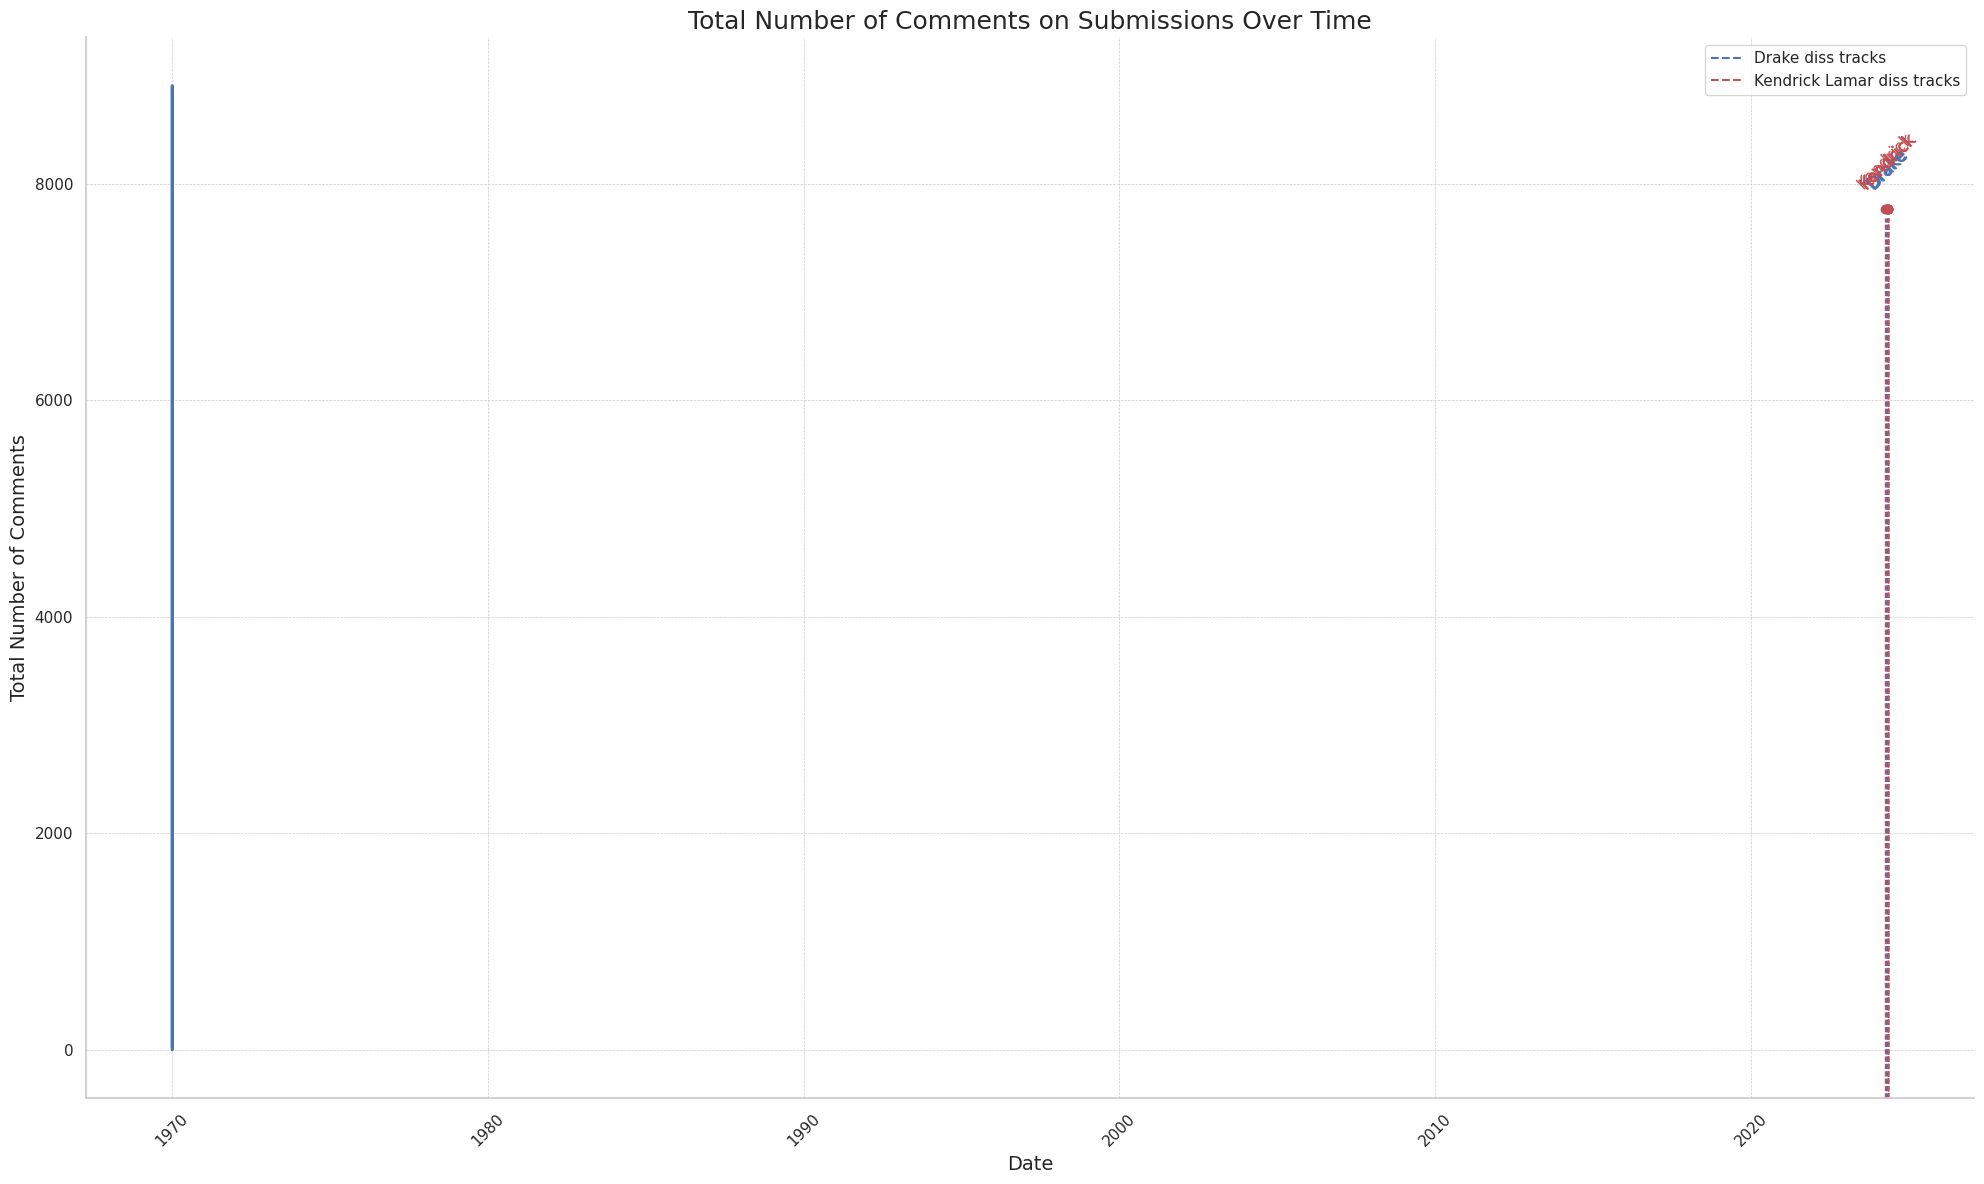

In [ ]:
# Function to plot vertical lines and annotations for diss tracks
def plot_disstrack(dates, color, name):
    for date in dates:
        date = pd.to_datetime(date)  # Convert string date to datetime
        plt.axvline(x=date, color=color, linestyle='--', linewidth=1, ymax=0.83)  # Draw a vertical line at the date
        plt.text(date, plt.gca().get_ylim()[1] * 0.85, name, color=color, rotation=45, ha='center')  # Annotate with artist's name
        plt.scatter(date, plt.gca().get_ylim()[1] * 0.83, color=color, zorder=5)  # Add a scatter point at the line's top

# Dates of diss tracks released by Drake and Kendrick Lamar
drake_diss_tracks = ['2024-04-13', '2024-04-19', '2024-05-03', '2024-05-05']
kendrick_diss_tracks = ['2024-03-26', '2024-04-30', '2024-05-03', '2024-05-03', '2024-05-04']

# Convert the 'created_utc' column to datetime for plotting
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Aggregate the total number of comments per day
comments_per_day = df.groupby('created_utc')['num_comments'].sum().reset_index(name='total_comments')

# Set up the figure for plotting
plt.figure(figsize=(20, 12))
sns.lineplot(data=comments_per_day, x='created_utc', y='total_comments', color='b', linewidth=2)  # Plot total comments over time

# Plot diss tracks for each artist
plot_disstrack(drake_diss_tracks, 'b', 'Drake')
plot_disstrack(kendrick_diss_tracks, 'r', 'Kendrick')

# Set plot titles and labels
plt.title('Total Number of Comments on Submissions Over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Number of Comments', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Enable grid for better readability
plt.xticks(rotation=45)  # Rotate date labels for better visibility
sns.despine()  # Remove right and top borders for a cleaner look

# Create custom legend handles to distinguish diss tracks
red_patch = plt.Line2D([0], [0], color='r', linestyle='--', label='Kendrick Lamar diss tracks')
blue_line = plt.Line2D([0], [0], color='b', linestyle='--', label='Drake diss tracks')
plt.legend(handles=[blue_line, red_patch], loc='upper right')  # Add legend to the plot

# Finalize layout and display the plot
plt.tight_layout()
plt.show()

Top 10 most used n-grams

In [ ]:
# Define a set of English stop words from NLTK
stop_words = set(stopwords.words('english'))
ngram_counter = Counter()

def get_ngrams(text, n):
    """
    Generates and returns n-grams from given text after removing stop words.
    
    Args:
    text (str): The text from which to generate n-grams.
    n (int): The number of words in each n-gram.
    
    Returns:
    list: A list of n-grams.
    """
    # Split the text into words and filter out any stop words
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Generate n-grams from the filtered list of words
    ngrams = zip(*[filtered_words[i:] for i in range(n)])  # Create sliding windows of size n
    return [' '.join(ngram) for ngram in ngrams]

def count_ngrams(texts, n):
    """
    Counts n-grams across a collection of texts.
    
    Args:
    texts (iterable of str): The texts to analyze.
    n (int): The number of words in each n-gram.
    
    Returns:
    Counter: A counter object mapping each n-gram to its frequency.
    """
    ngram_counter = Counter()
    for text in texts:
        ngrams = get_ngrams(text, n)
        ngram_counter.update(ngrams)
    return ngram_counter

Most popular unigrams

In [ ]:
# Specify the number of words in each n-gram
n = 1
# Count n-grams in the 'text' column of the dataframe
ngram_counter = count_ngrams(df['text'], n)

# Choose the number of top n-grams to display
top_n = 20
# Get the most common n-grams and their counts
top_n_ngrams = ngram_counter.most_common(top_n)

# Unzip the list of tuples to separate n-grams and their counts
ngrams, counts = zip(*top_n_ngrams)
# Create a DataFrame for easy plotting
ngrams_df = pd.DataFrame({'ngram': ngrams, 'count': counts})

# Plot the histogram of the top n-grams
plt.figure(figsize=(14, 8))
sns.barplot(data=ngrams_df, x='ngram', y='count', palette='viridis')
plt.title(f'Top {top_n} Most Used {n}-grams in Text', fontsize=18)
plt.xlabel('N-grams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

Most popular bigrams

<ipython-input-382-52f057ae0198>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ngrams_df, x='ngram', y='count', palette='viridis')


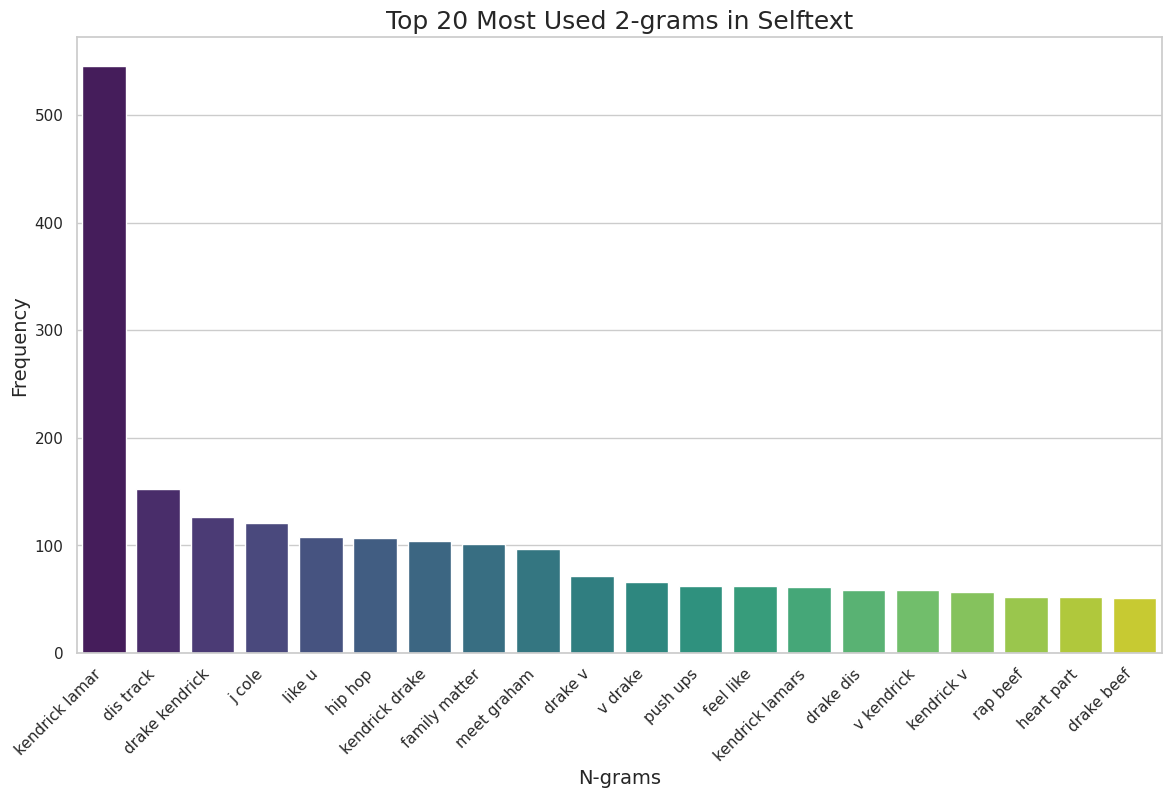

In [ ]:
# Set the number of words in each n-gram to 2
n = 2
# Count n-grams in the 'text' column of the dataframe
ngram_counter = count_ngrams(df['text'], n)

# Choose the number of top n-grams to display
top_n = 20
# Get the most common n-grams and their counts
top_n_ngrams = ngram_counter.most_common(top_n)

# Unzip the list of tuples to separate n-grams and their counts
ngrams, counts = zip(*top_n_ngrams)
# Create a DataFrame for easy plotting
ngrams_df = pd.DataFrame({'ngram': ngrams, 'count': counts})

# Plot the histogram of the top n-grams
plt.figure(figsize=(14, 8))
sns.barplot(data=ngrams_df, x='ngram', y='count', palette='viridis')
plt.title(f'Top {top_n} Most Used 2-grams in Text', fontsize=18)
plt.xlabel('N-grams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

Locked submissions

<ipython-input-186-41a70fb459a2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='locked', palette='viridis')


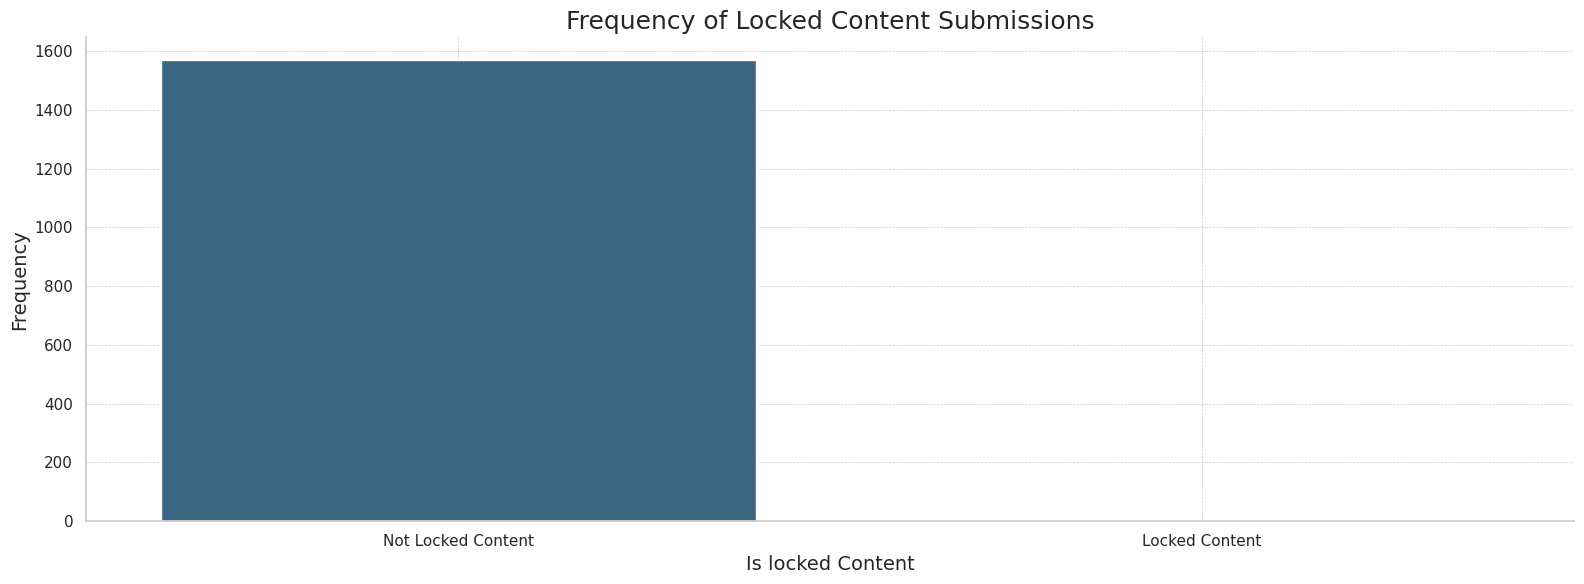

In [ ]:
# Set the size of the plot
plt.figure(figsize=(16, 6))

# Create a count plot using Seaborn
sns.countplot(data=df, x='locked', palette='viridis')

# Add a title to the plot
plt.title('Frequency of Locked Content Submissions', fontsize=18)

# Label the x-axis
plt.xlabel('Is Locked Content', fontsize=14)

# Label the y-axis
plt.ylabel('Frequency', fontsize=14)

# Define the labels for the x-ticks for clarity
plt.xticks([0, 1], ['Not Locked Content', 'Locked Content'])

# Add a grid for easier readability of the plot
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove the top and right borders for a cleaner look
sns.despine()

# Ensure all elements are well-placed and not clipped
plt.tight_layout()

# Display the plot
plt.show()

We have no locked submissions meaning all the submissions have an open comment section.

Number of submissions for each subreddit

<ipython-input-187-a13b4ac37b62>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subreddit_counts, x='subreddit', y='count', palette='viridis')


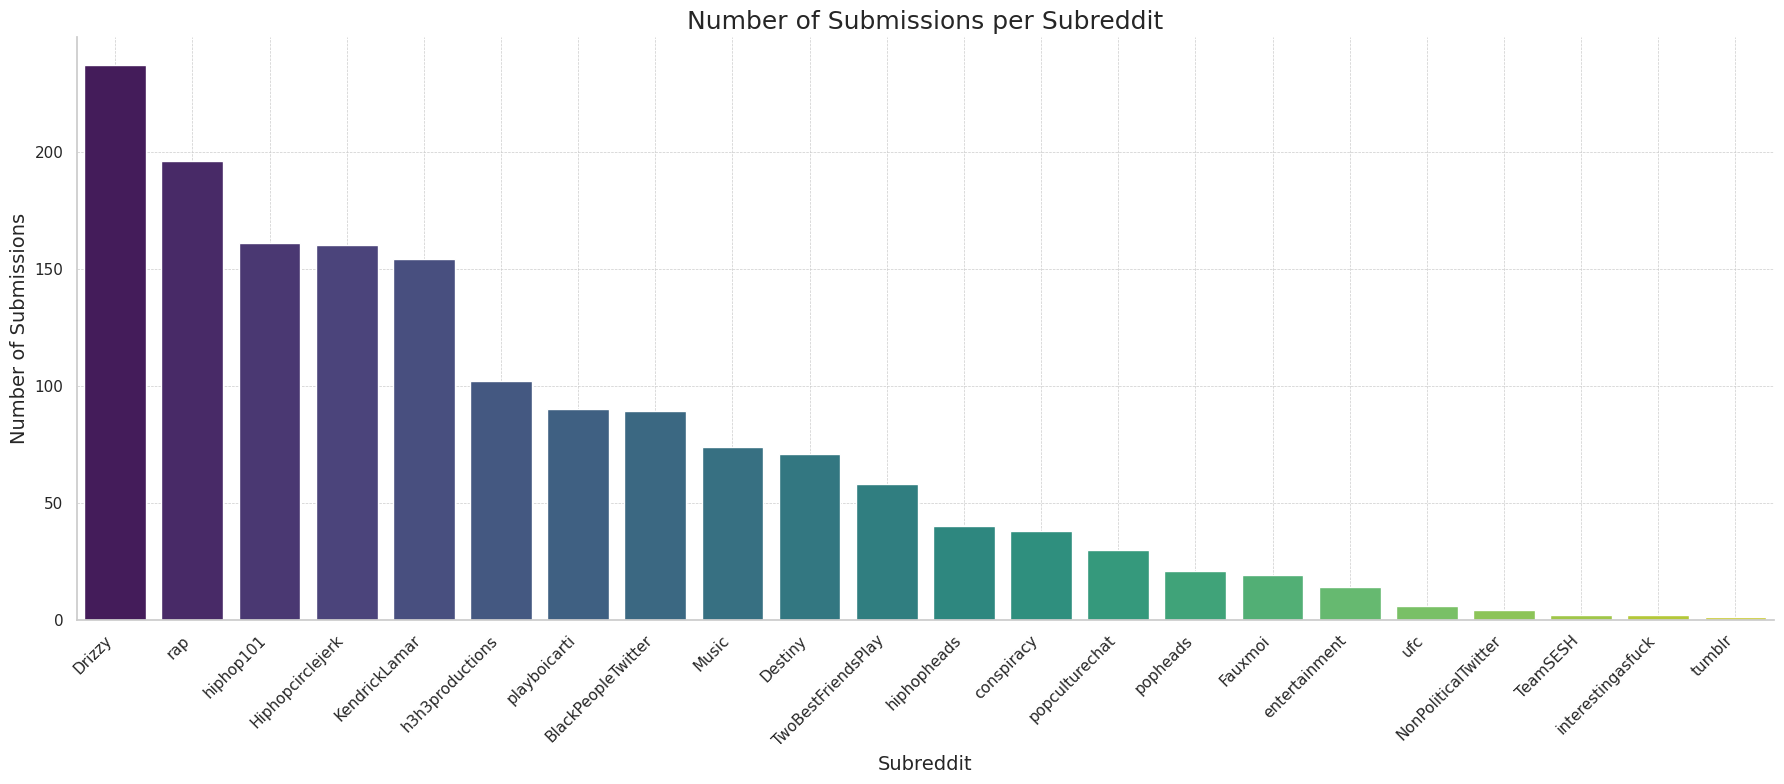

In [ ]:
# Count the occurrences of each subreddit and reset the index to create a DataFrame
subreddit_counts = df['subreddit'].value_counts().reset_index()

# Rename columns to 'subreddit' and 'count' for clarity
subreddit_counts.columns = ['subreddit', 'count']

# Set the size of the plot
plt.figure(figsize=(18, 8))

# Create a bar plot showing the number of submissions per subreddit using Seaborn
sns.barplot(data=subreddit_counts, x='subreddit', y='count', palette='viridis')

# Add a title to the plot
plt.title('Number of Submissions per Subreddit', fontsize=18)

# Label the x-axis
plt.xlabel('Subreddit', fontsize=14)

# Label the y-axis
plt.ylabel('Number of Submissions', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid lines to the plot for better readability of the values
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove the top and right frame lines to make the plot cleaner
sns.despine()

# Adjust the layout to make sure everything fits and is displayed correctly
plt.tight_layout()

# Display the plot
plt.show()

###Subreddit scores

<ipython-input-188-988cbb2994ab>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subreddit_score, x='subreddit', y='avg_score', palette='viridis')


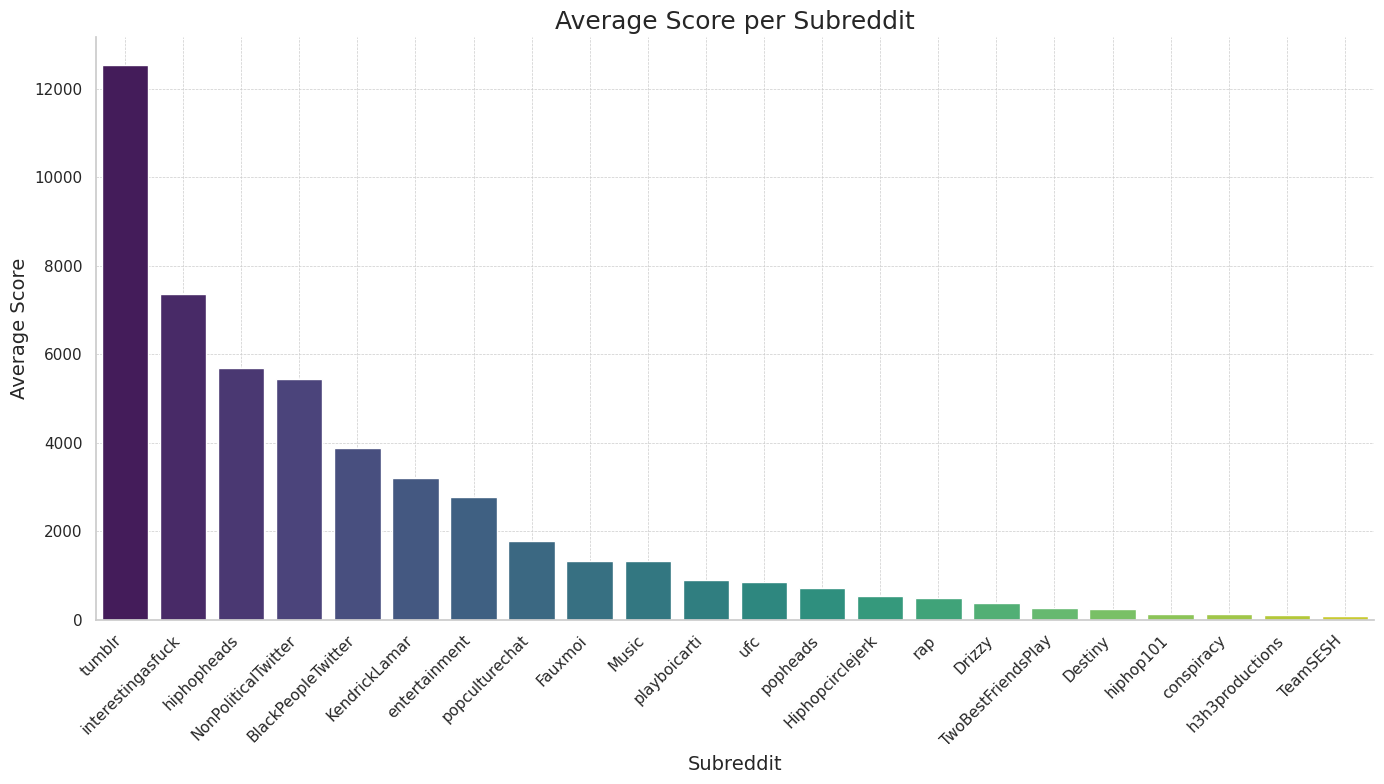

In [ ]:
# Group by subreddit to calculate the average upvote ratio per subreddit
subreddit_score = df.groupby('subreddit')['score'].mean().reset_index()
subreddit_score.columns = ['subreddit', 'avg_score']

# Sort by average upvote ratio
subreddit_score = subreddit_score.sort_values(by='avg_score', ascending=False)

# Plotting the average upvote ratio per subreddit
plt.figure(figsize=(14, 8))
sns.barplot(data=subreddit_score, x='subreddit', y='avg_score', palette='viridis')

# Enhance the appearance
plt.title('Average Score per Subreddit', fontsize=18)
plt.xlabel('Subreddit', fontsize=14)
plt.ylabel('Average Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

###Ranking each subbredit by their score

<ipython-input-189-7cc3c1619b04>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subreddit_stats, x='subreddit', y='count', palette='viridis', order=subreddit_stats['subreddit'])


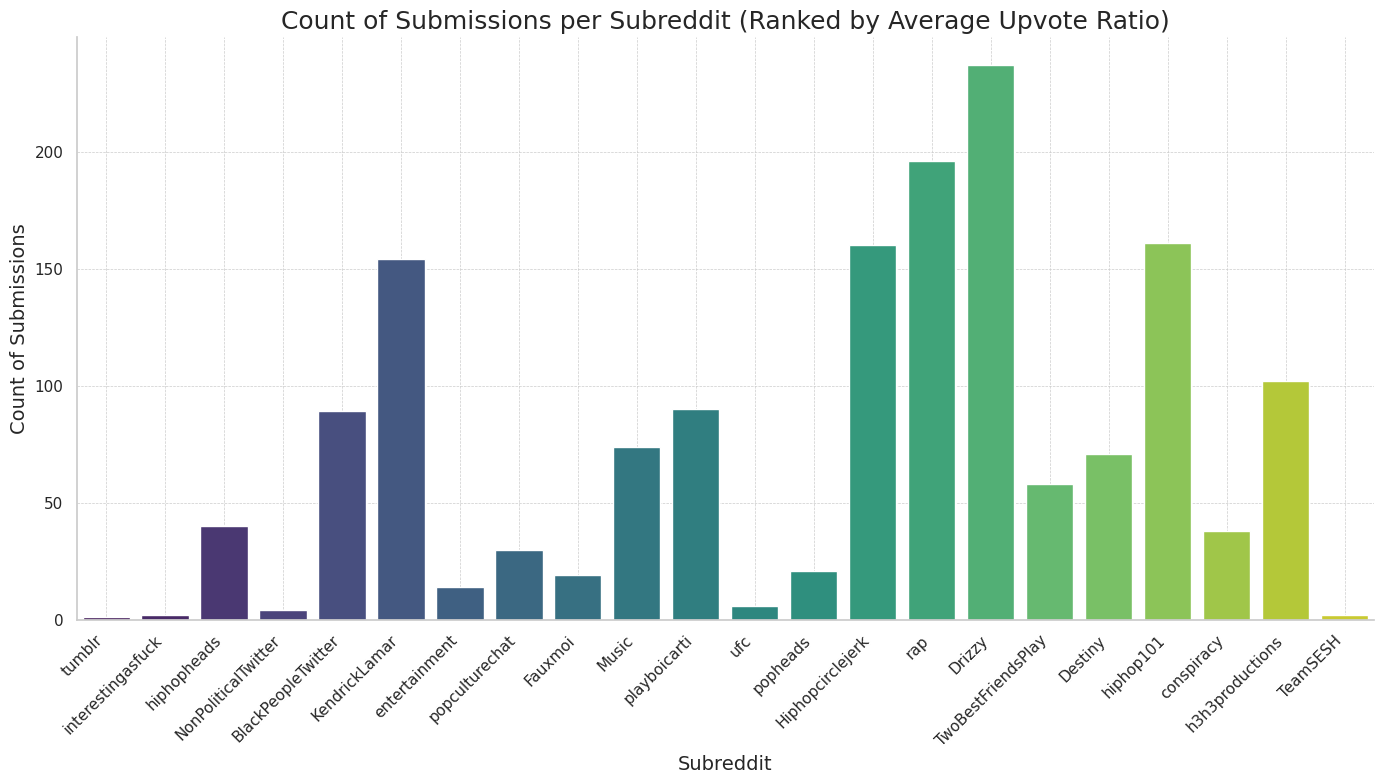

In [ ]:
# Aggregate the data by subreddit, computing the total count and average score ratio for each subreddit
subreddit_stats = df.groupby('subreddit').agg(
    count=('subreddit', 'size'),           # Count the number of submissions per subreddit
    avg_score_ratio=('score', 'mean')      # Calculate the average score ratio (upvotes to downvotes) for submissions
).reset_index()                            # Reset index to turn 'subreddit' back into a column

# Sort the subreddit statistics by average score ratio in descending order
subreddit_stats = subreddit_stats.sort_values(by='avg_score_ratio', ascending=False)

# Set up the figure for plotting
plt.figure(figsize=(14, 8))

# Create a bar plot showing the count of submissions for each subreddit, 
# ordered by the average score ratio to highlight the influence of positive reception
sns.barplot(data=subreddit_stats, x='subreddit', y='count', palette='viridis', order=subreddit_stats['subreddit'])

# Set the title and axis labels with appropriate font sizes
plt.title('Count of Submissions per Subreddit (Ranked by Average Upvote Ratio)', fontsize=18)
plt.xlabel('Subreddit', fontsize=14)
plt.ylabel('Count of Submissions', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid lines to the plot for better readability of the values
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove the top and right frame lines to make the plot cleaner
sns.despine()

# Adjust the layout to make sure everything fits and is displayed correctly
plt.tight_layout()

# Display the plot
plt.show()

This graph shows the count of submissions for each subbredit but this time ranked by their score from highest to lowest in order to establish some sort of relevance or legitimacy for each subreddit regardless of their size. We can see that mostly big subreddits have low scores.

###Subreddits and spoilers

<ipython-input-190-f79ff36b0a3d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subreddit_spoilers, x='subreddit', y='count', palette='viridis')


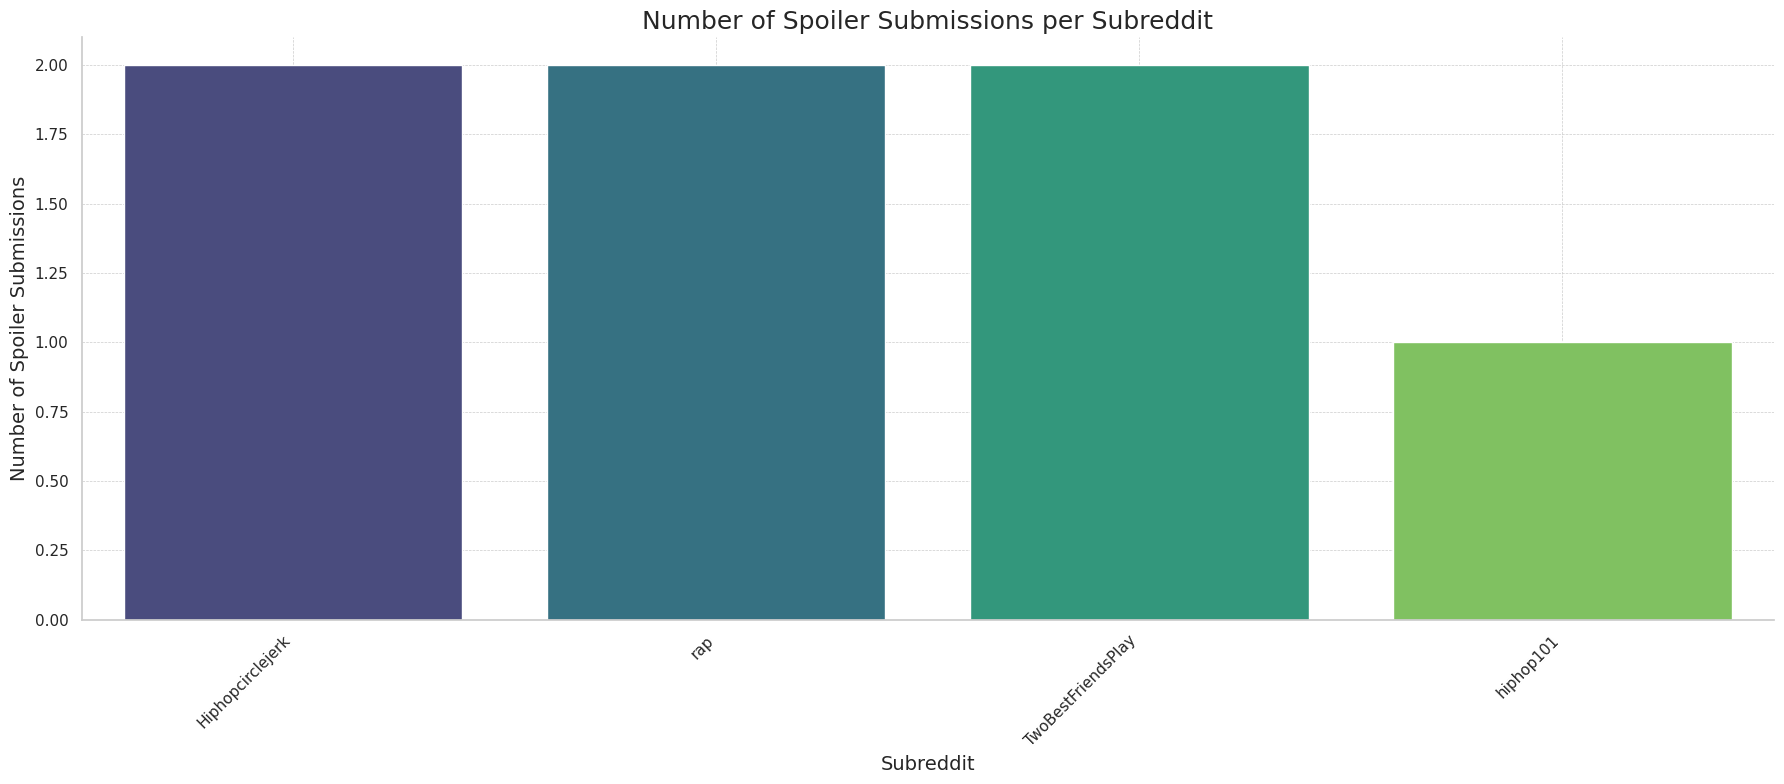

In [ ]:
# Filter the DataFrame to include only rows where the 'spoiler' column is True
spoiler_data = df[df['spoiler'] == True]

# Count the number of spoiler submissions per subreddit and reset the index to create a DataFrame
subreddit_spoilers = spoiler_data['subreddit'].value_counts().reset_index()

# Rename the columns for clarity
subreddit_spoilers.columns = ['subreddit', 'count']

# Sort the DataFrame by the count of spoiler submissions in descending order
subreddit_spoilers = subreddit_spoilers.sort_values(by='count', ascending=False)

# Set up the figure for plotting with specified dimensions
plt.figure(figsize=(18, 8))

# Create a bar plot showing the number of spoiler submissions per subreddit using Seaborn
sns.barplot(data=subreddit_spoilers, x='subreddit', y='count', palette='viridis')

# Set the title and axis labels for the plot with appropriate font sizes
plt.title('Number of Spoiler Submissions per Subreddit', fontsize=18)
plt.xlabel('Subreddit', fontsize=14)
plt.ylabel('Number of Spoiler Submissions', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid lines to the plot for better readability of the values
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove the top and right frame lines to make the plot cleaner
sns.despine()

# Adjust the layout to make sure everything fits and is displayed correctly
plt.tight_layout()

# Display the plot
plt.show()

Spoilers in such subreddits are very rare, unlike in other subbreddits related to anime, serials or movies.

##Comments

In [ ]:

# Load the comments DataFrame from a CSV file
comments_df = pd.read_csv('data/final_comments_dataframe.csv')

# Display the first few rows of the DataFrame to get an initial look at the data
print(comments_df.head())

# Print a concise summary of the DataFrame, including data types and non-null values count
comments_df.info()

# Generate descriptive statistics, including specified percentiles, and transpose for easier reading
descriptive_stats = comments_df.describe(percentiles=[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25, 0.50, 0.75, 0.90, 0.99]).T
print(descriptive_stats)

# Check for missing values in each column and print the count
null_counts = comments_df.isnull().sum()
print(null_counts)

# Drop rows with any missing values and modify the DataFrame in place
comments_df.dropna(inplace=True)

# Verify that there are no more missing values after dropping the rows
null_counts_after_dropping = comments_df.isnull().sum()
print(null_counts_after_dropping)

Missing commenta can be a result of preprocessing. Some comments probably consisted of links or just emojis so they were reduced to nothing.

Number of comments each day a diss drops

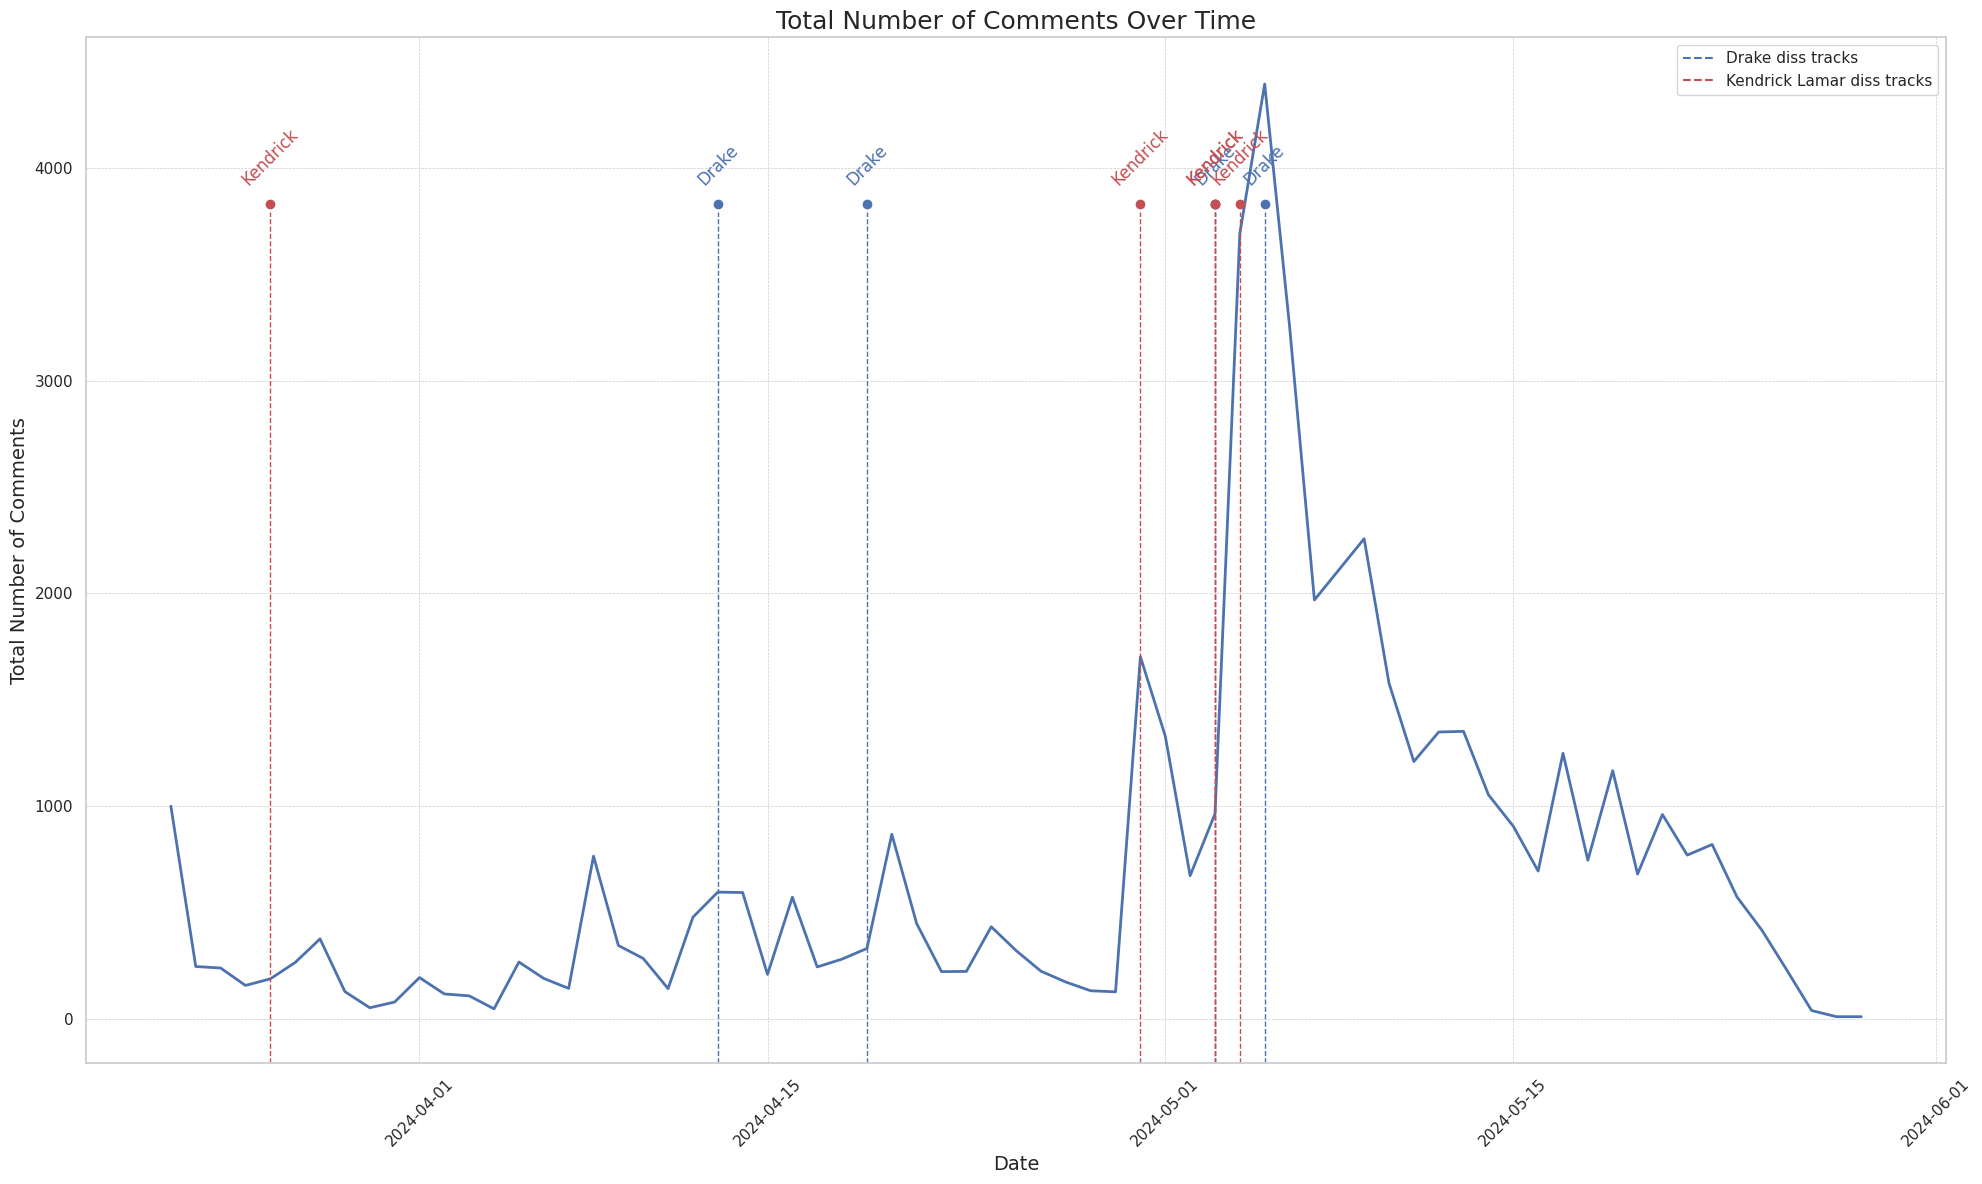

In [ ]:
# Convert 'created_utc' column to datetime format
comments_df['created_utc'] = pd.to_datetime(comments_df['created_utc'])

# Group comments by date and count the number of comments per day
comments_per_day = comments_df.groupby(comments_df['created_utc'].dt.date).size().reset_index(name='total_comments')

# Convert the 'created_utc' column back to datetime format for consistency in plotting
comments_per_day['created_utc'] = pd.to_datetime(comments_per_day['created_utc'])

# Set up the figure for plotting with specified dimensions
plt.figure(figsize=(20, 12))

# Create a line plot showing the total number of comments over time
sns.lineplot(data=comments_per_day, x='created_utc', y='total_comments', color='b', linewidth=2)

# Plot diss tracks for Drake
plot_disstrack(drake_diss_tracks, 'b', 'Drake')

# Plot diss tracks for Kendrick Lamar
plot_disstrack(kendrick_diss_tracks, 'r', 'Kendrick')

# Set the title and labels for the plot with appropriate font sizes
plt.title('Total Number of Comments Over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Number of Comments', fontsize=14)

# Add grid lines to the plot for better readability of the values
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Create custom legend handles to distinguish diss tracks for each artist
red_patch = plt.Line2D([0], [0], color='r', linestyle='--', label='Kendrick Lamar diss tracks')
blue_line = plt.Line2D([0], [0], color='b', linestyle='--', label='Drake diss tracks')

# Add the legend to the plot
plt.legend(handles=[blue_line, red_patch], loc='upper right')

# Adjust the layout to make sure everything fits and is displayed correctly
plt.tight_layout()

# Display the plot
plt.show()

Top 10 with the highest scores

<ipython-input-333-fc9c517f3bfb>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_users, x='user', y='score', palette='viridis')


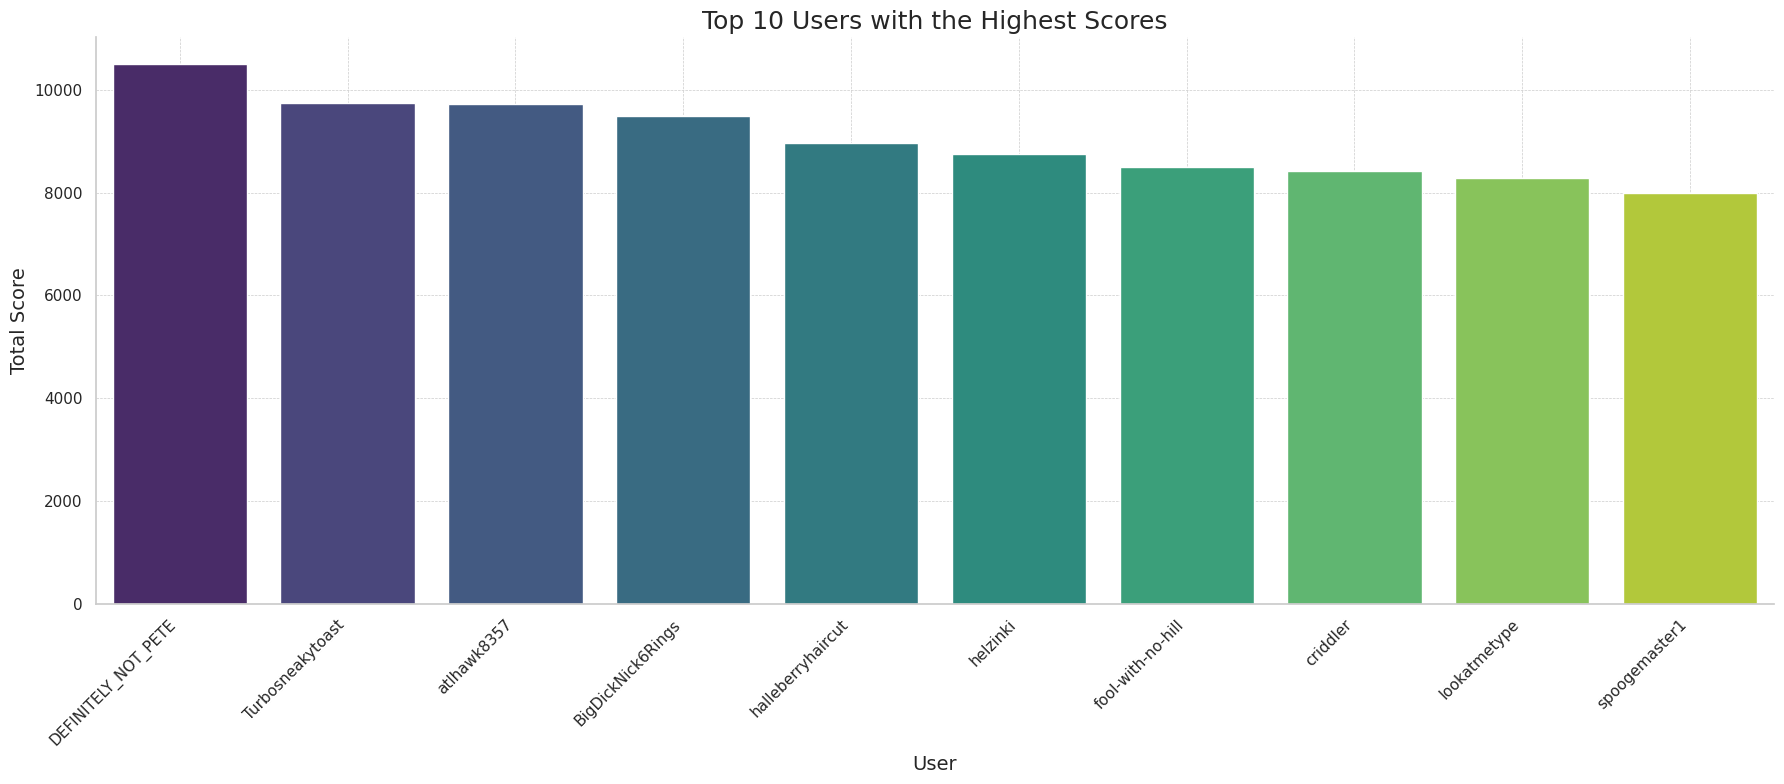

In [ ]:
user_scores = comments_df.groupby('user')['score'].mean().reset_index()

# Sort the data by total scores in descending order
user_scores = user_scores.sort_values(by='score', ascending=False)

# Select the top 10 users with the highest scores
top_10_users = user_scores.head(10)

# Plotting the data
plt.figure(figsize=(18, 8))
sns.barplot(data=top_10_users, x='user', y='score', palette='viridis')

# Enhance the appearance
plt.title('Top 10 Users with the Highest Scores', fontsize=18)
plt.xlabel('User', fontsize=14)
plt.ylabel('Total Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

Most popular unigrams

<ipython-input-391-119dfbc9dd94>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ngrams_df, x='ngram', y='count', palette='viridis')


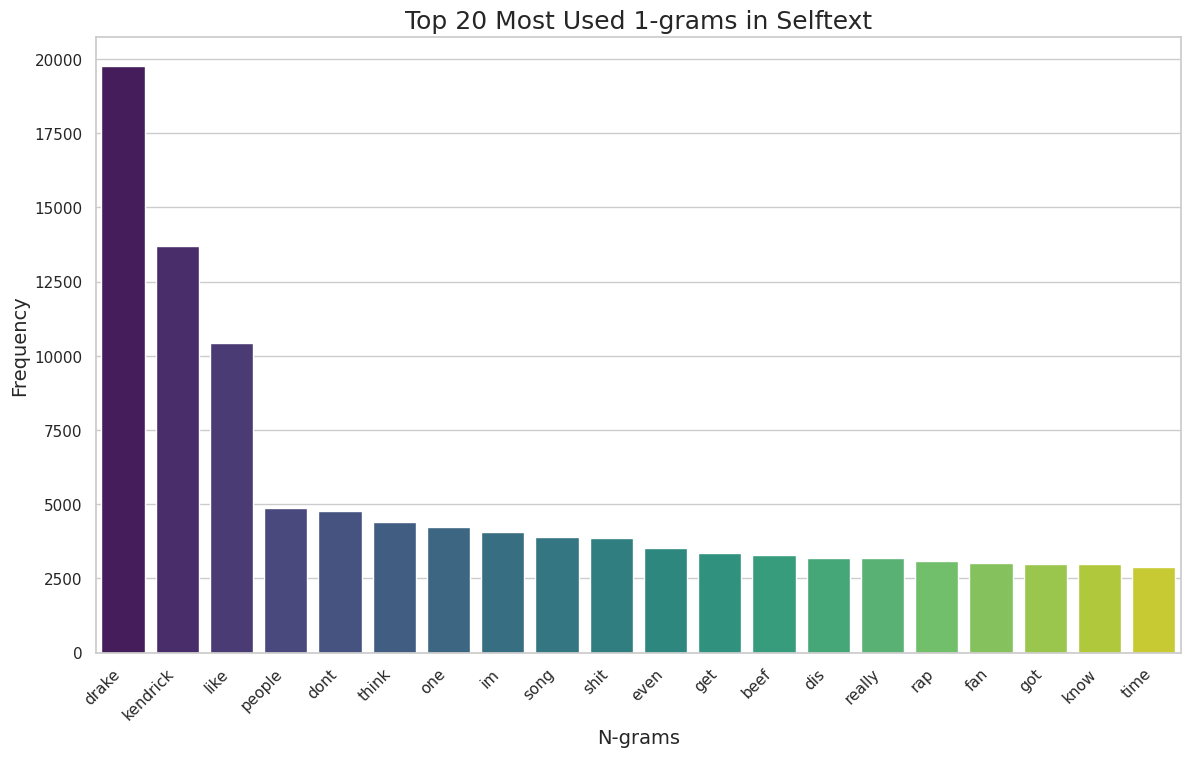

In [ ]:
# Define the number of words in each n-gram
n = 1

# Count the n-grams in the 'comment' column of the DataFrame
ngram_counter = count_ngrams(comments_df['comment'], n)

# Select the top n most common n-grams
top_n = 20
top_n_ngrams = ngram_counter.most_common(top_n)

# Unzip the list of tuples into two separate lists: ngrams and their counts
ngrams, counts = zip(*top_n_ngrams)

# Create a DataFrame for easier plotting
ngrams_df = pd.DataFrame({'ngram': ngrams, 'count': counts})

# Set up the figure for plotting
plt.figure(figsize=(14, 8))

# Create a bar plot showing the most frequently used n-grams
sns.barplot(data=ngrams_df, x='ngram', y='count', palette='viridis')

# Set the title and labels for the plot with appropriate font sizes
plt.title(f'Top {top_n} Most Used {n}-grams in Comments', fontsize=18)
plt.xlabel('N-grams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotate the x-axis labels for better readability, especially useful for long n-grams
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

Most popular bigrams

<ipython-input-390-aab5f5603fd2>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ngrams_df, x='ngram', y='count', palette='viridis')


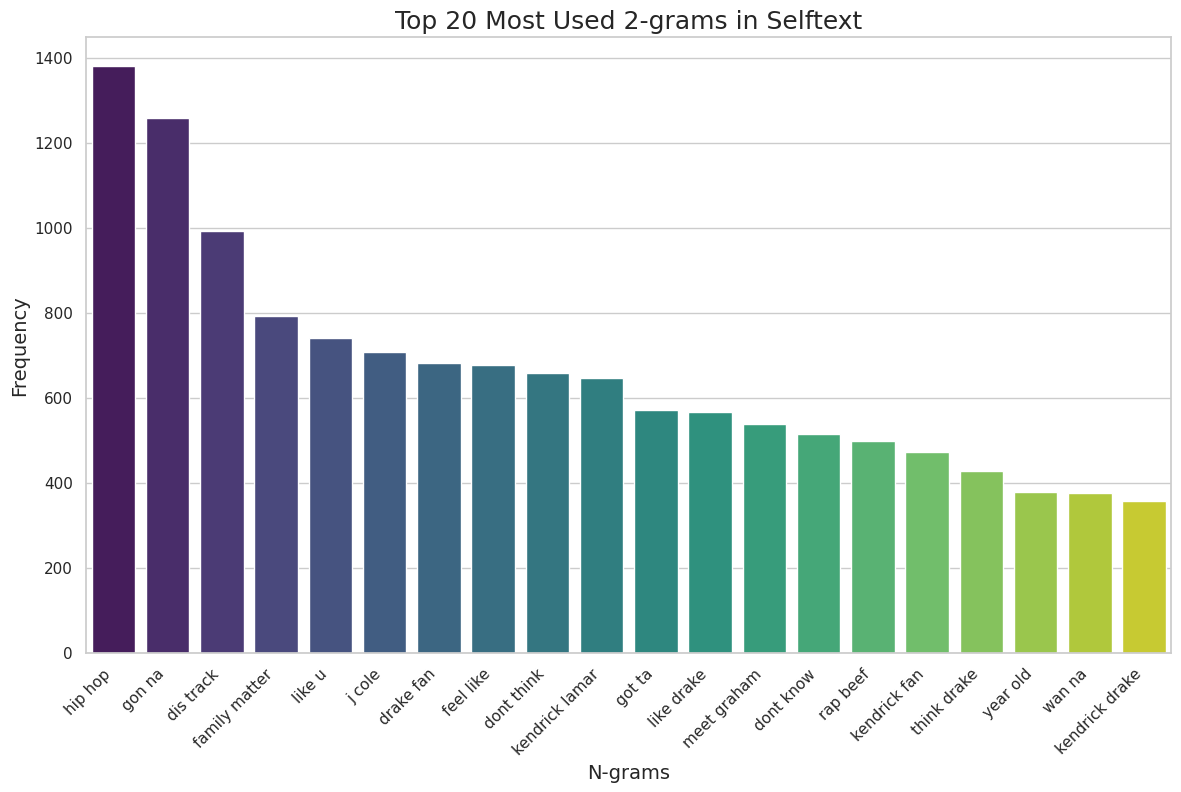

In [ ]:
# Define the number of words in each n-gram
n = 2

# Count the n-grams in the 'comment' column of the DataFrame
ngram_counter = count_ngrams(comments_df['comment'], n)

# Select the top n most common n-grams
top_n = 20
top_n_ngrams = ngram_counter.most_common(top_n)

# Unzip the list of tuples into two separate lists: ngrams and their counts
ngrams, counts = zip(*top_n_ngrams)

# Create a DataFrame for easier plotting
ngrams_df = pd.DataFrame({'ngram': ngrams, 'count': counts})

# Set up the figure for plotting
plt.figure(figsize=(14, 8))

# Create a bar plot showing the most frequently used 2-grams
sns.barplot(data=ngrams_df, x='ngram', y='count', palette='viridis')

# Set the title and labels for the plot with appropriate font sizes
plt.title(f'Top {top_n} Most Used {n}-grams in Comments', fontsize=18)
plt.xlabel('N-grams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Rotate the x-axis labels for better readability, especially useful for long n-grams
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()